# DSCI 100 Project - Group 12
Authors:  

Tia Murdoch 719191378

Sam Wang 70602008

Hanna Ross 40955320

Maan Grover 62953260

# Introduction

Raisins are dried grapes and they are eaten all over the world. The small dehydrated fruit can be eaten on its own or is often used in cooking and baking. Raisins will obtain their primary differences from the type of grape used to produce them, as well as the drying method.

The chosen dataset was created by processing images of raisins and taking measurements of morphological features (area, convex area, major axis length, minor axis length, perimeter, eccentricity, and extent) using the number of pixels in the image as a meaurement. Then using three different types of artificial intelligence, each raisin was classified as either Kecimen or Besni, both of which are popular in Turkey.  

Besni raisins are produced from the Sultana grape, and are characterized by their small, oval shape and light brown color. The Kecimen raisins are made from Black Corinth grapes. They are dark brown, round, and smooth. They are also generally smaller than Besni raisins.



# Methods & Results
This study use k-nn classification method to classify type of raisin.

Since we changed our dataset after proposal submission, we will do a more detailed preliminary exploratory data analysis first.
Then we will determine which variables have the strongest relationships to determine diffrent types of raisin, and then set them as the predictors.

Steps of k-nn Classification model building (exploratory data analysis):

1. Create Recipe

2. Cross-Validate the data

3. Workflow and Fit

4. Use our classifier to predict the testing data

5. Evaluate the accuracy of our model

6. Create visualizasions that compare true model and trained model

## Load Data

In [42]:
#load library
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(GGally)
library(digest)
library(cowplot)
library(gridExtra)
#set seed
set.seed(123)

In [43]:
#read data set
raisin <- read_csv("https://raw.githubusercontent.com/tmurdoch1/DSCI100-project/main/Raisin_Dataset.csv")
#print data
glimpse(raisin)

Rows: 900 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (7): Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 900
Columns: 8
$ Area            <dbl> 87524, 75166, 90856, 45928, 79408, 49242, 42492, 60952…
$ MajorAxisLength <dbl> 442.2460, 406.6907, 442.2670, 286.5406, 352.1908, 318.…
$ MinorAxisLength <dbl> 253.2912, 243.0324, 266.3283, 208.7600, 290.8275, 200.…
$ Eccentricity    <dbl> 0.8197384, 0.8018052, 0.7983536, 0.6849892, 0.5640113,…
$ ConvexArea      <dbl> 90546, 78789, 93717, 47336, 81463, 51368, 43904, 62329…
$ Extent          <dbl> 0.7586506, 0.6841296, 0.6376128, 0.6995994, 0.7927719,…
$ Perimeter       <dbl> 1184.040, 1121.786, 1208.575, 844.162, 1073.251, 881.8…
$ Class           <chr> "Kecimen", "Kecimen", "Kecimen", "Kecimen", "Kecimen",…


## Wrangle and Clean the data

The column names in the data set were already human-readable, thus they did not need to be renamed. Furthermore, the data was already in a tidy format - each column is a single variable, each row has a single observation and each cell is a single value, meaning that there was not a large amount of data wrangling to carry. The only operation that was carried out is the transformation of the `Class` colum from chr to fct format so that it could be used later on in the creation of the classification model. 


In [44]:
raisin <- mutate(raisin, Class = as_factor(Class))
head(raisin, n=5)

Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen


The clean data is then split  into training and testing data with prop = 0.75, meaning that 75% of the data will be assigned to the training group. Note: the units of all measurements are number of pixels and will be omitted moving forward. 

In [45]:
raisin_split <- initial_split(raisin, prop = .75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)

## Summarize the data
To give an overview of the training data:
1) summarize the mean value for each predictors
2) count the number of observation for each class
3) find out number of missing row
4) check our data is balanced


In [46]:
# 1&2)summarize mean and number of observations in a table
raisin_summarize <- raisin_train |>
    group_by(Class) |>
    summarize(Area_mean = mean(Area), MajorAxisLength_mean = mean(MajorAxisLength), MinorAxisLength_mean = mean(MinorAxisLength),
              Eccentricity_mean = mean(Eccentricity), ConvexArea_mean = mean(ConvexArea), Extent_mean = mean(Extent), 
                  Perimeter_mean = mean(Perimeter), observations = n())
raisin_summarize

Class,Area_mean,MajorAxisLength_mean,MinorAxisLength_mean,Eccentricity_mean,ConvexArea_mean,Extent_mean,Perimeter_mean,observations
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Kecimen,63994.55,355.2678,230.0726,0.7435603,66255.53,0.7071761,988.8967,337
Besni,110053.10,503.0439,277.7713,0.8196521,114424.92,0.6909313,1335.9067,337


In [47]:
# 3)find out number of missing row
sum(is.na(raisin_train))

[1] 0

There is no `na.` value in the data frame, which indicates there are not any missing rows.

In [48]:
# 4)check the proportion of classes in both whole data set and training data set
whole_raisin_proportions <- raisin |>
                      group_by(Class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(raisin))
whole_raisin_proportions

raisin_proportions <- raisin_train |>
                      group_by(Class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(raisin_train))
raisin_proportions



Class,n,percent
<fct>,<int>,<dbl>
Kecimen,450,50
Besni,450,50


Class,n,percent
<fct>,<int>,<dbl>
Kecimen,337,50
Besni,337,50


As evidenced by the above tables (whole raisin proportions - upper tibble; training raisin proportions - lower tibble), the proportions of each class are balanced in both the whole data set and training data set. This simplifies our classification process to some extent due to the fact that we do not have a dominating class. When one class is overrepresented, new observations are more likely to be deemed to be of the overrepresented class. Altering the classifier to solve this problem is very complex, but if it were necessary, the step_upsample can be used to multiply the underrepresented class, thus balancing the classifier and improving accuracy. 

## Visualize the Data
Now we find suitable predictors in our data by visualization.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



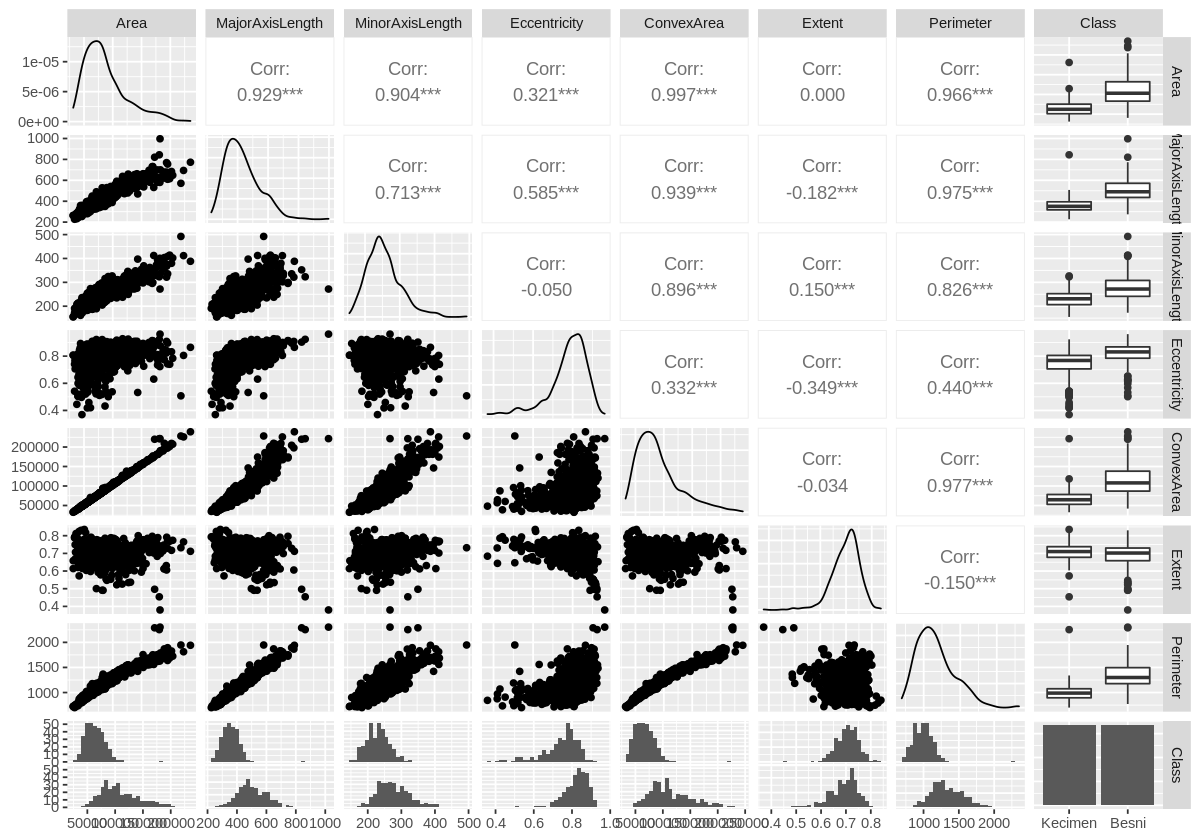

In [49]:
#Use ggpairs function to look at relationship between different variables. 
ggpairs(raisin_train)
options(repr.plot.width = 12, repr.plot.height = 12)

Figure 1: Matrix displaying the relationship between all seven characteristics present in the raisin dataset. 

The above plots were analyzed in two ways to determine which variables to choose for the classifier: (1) qualitatively to look at whether the variable resulted in linear plots when plotted against other variables and (2)quantitatively - all four chosen had a significant difference in values between each class, as evidenced by the whisker plots. The four chosen v
- Area
- Majour Axis Length
- Convex area 
- Perimeter

Those variables were then plotted against each other. 

In [34]:
plot_1 <- raisin_train |>
    ggplot(aes(x = Area, y = MajorAxisLength, color = Class)) +
    geom_point() +
    labs(x = "Area", y = "Major Axis Length", title = , subtitle = )

plot_2 <- raisin_train |>
    ggplot(aes(x = Area, y = Perimeter, color = Class)) +
    geom_point() +
    labs(x = "Area", y = "Perimeter", color = "Class")

plot_3 <- raisin_train |>
    ggplot(aes(x = Area, y = ConvexArea, color = Class)) +
    geom_point() +
    labs(x = "Perimeter", y = "Convex Area")

plot_4 <- raisin_train |>
    ggplot(aes(x = MajorAxisLength, y = ConvexArea, color = Class)) +
    geom_point() +
    labs(x = "Major Axis Length", y = "Convex Area", color = "Class")

plot_5 <- raisin_train |>
    ggplot(aes(x = MajorAxisLength, y = Perimeter, color = Class)) +
    geom_point() +
    labs(x = "Major Axis Length", y = "Perimeter")

plot_6 <- raisin_train |>
    ggplot(aes(x = ConvexArea, y = Perimeter, color = Class)) +
    geom_point() +
    labs(x = "Convex Area", y = "Perimeter", color = "Class")

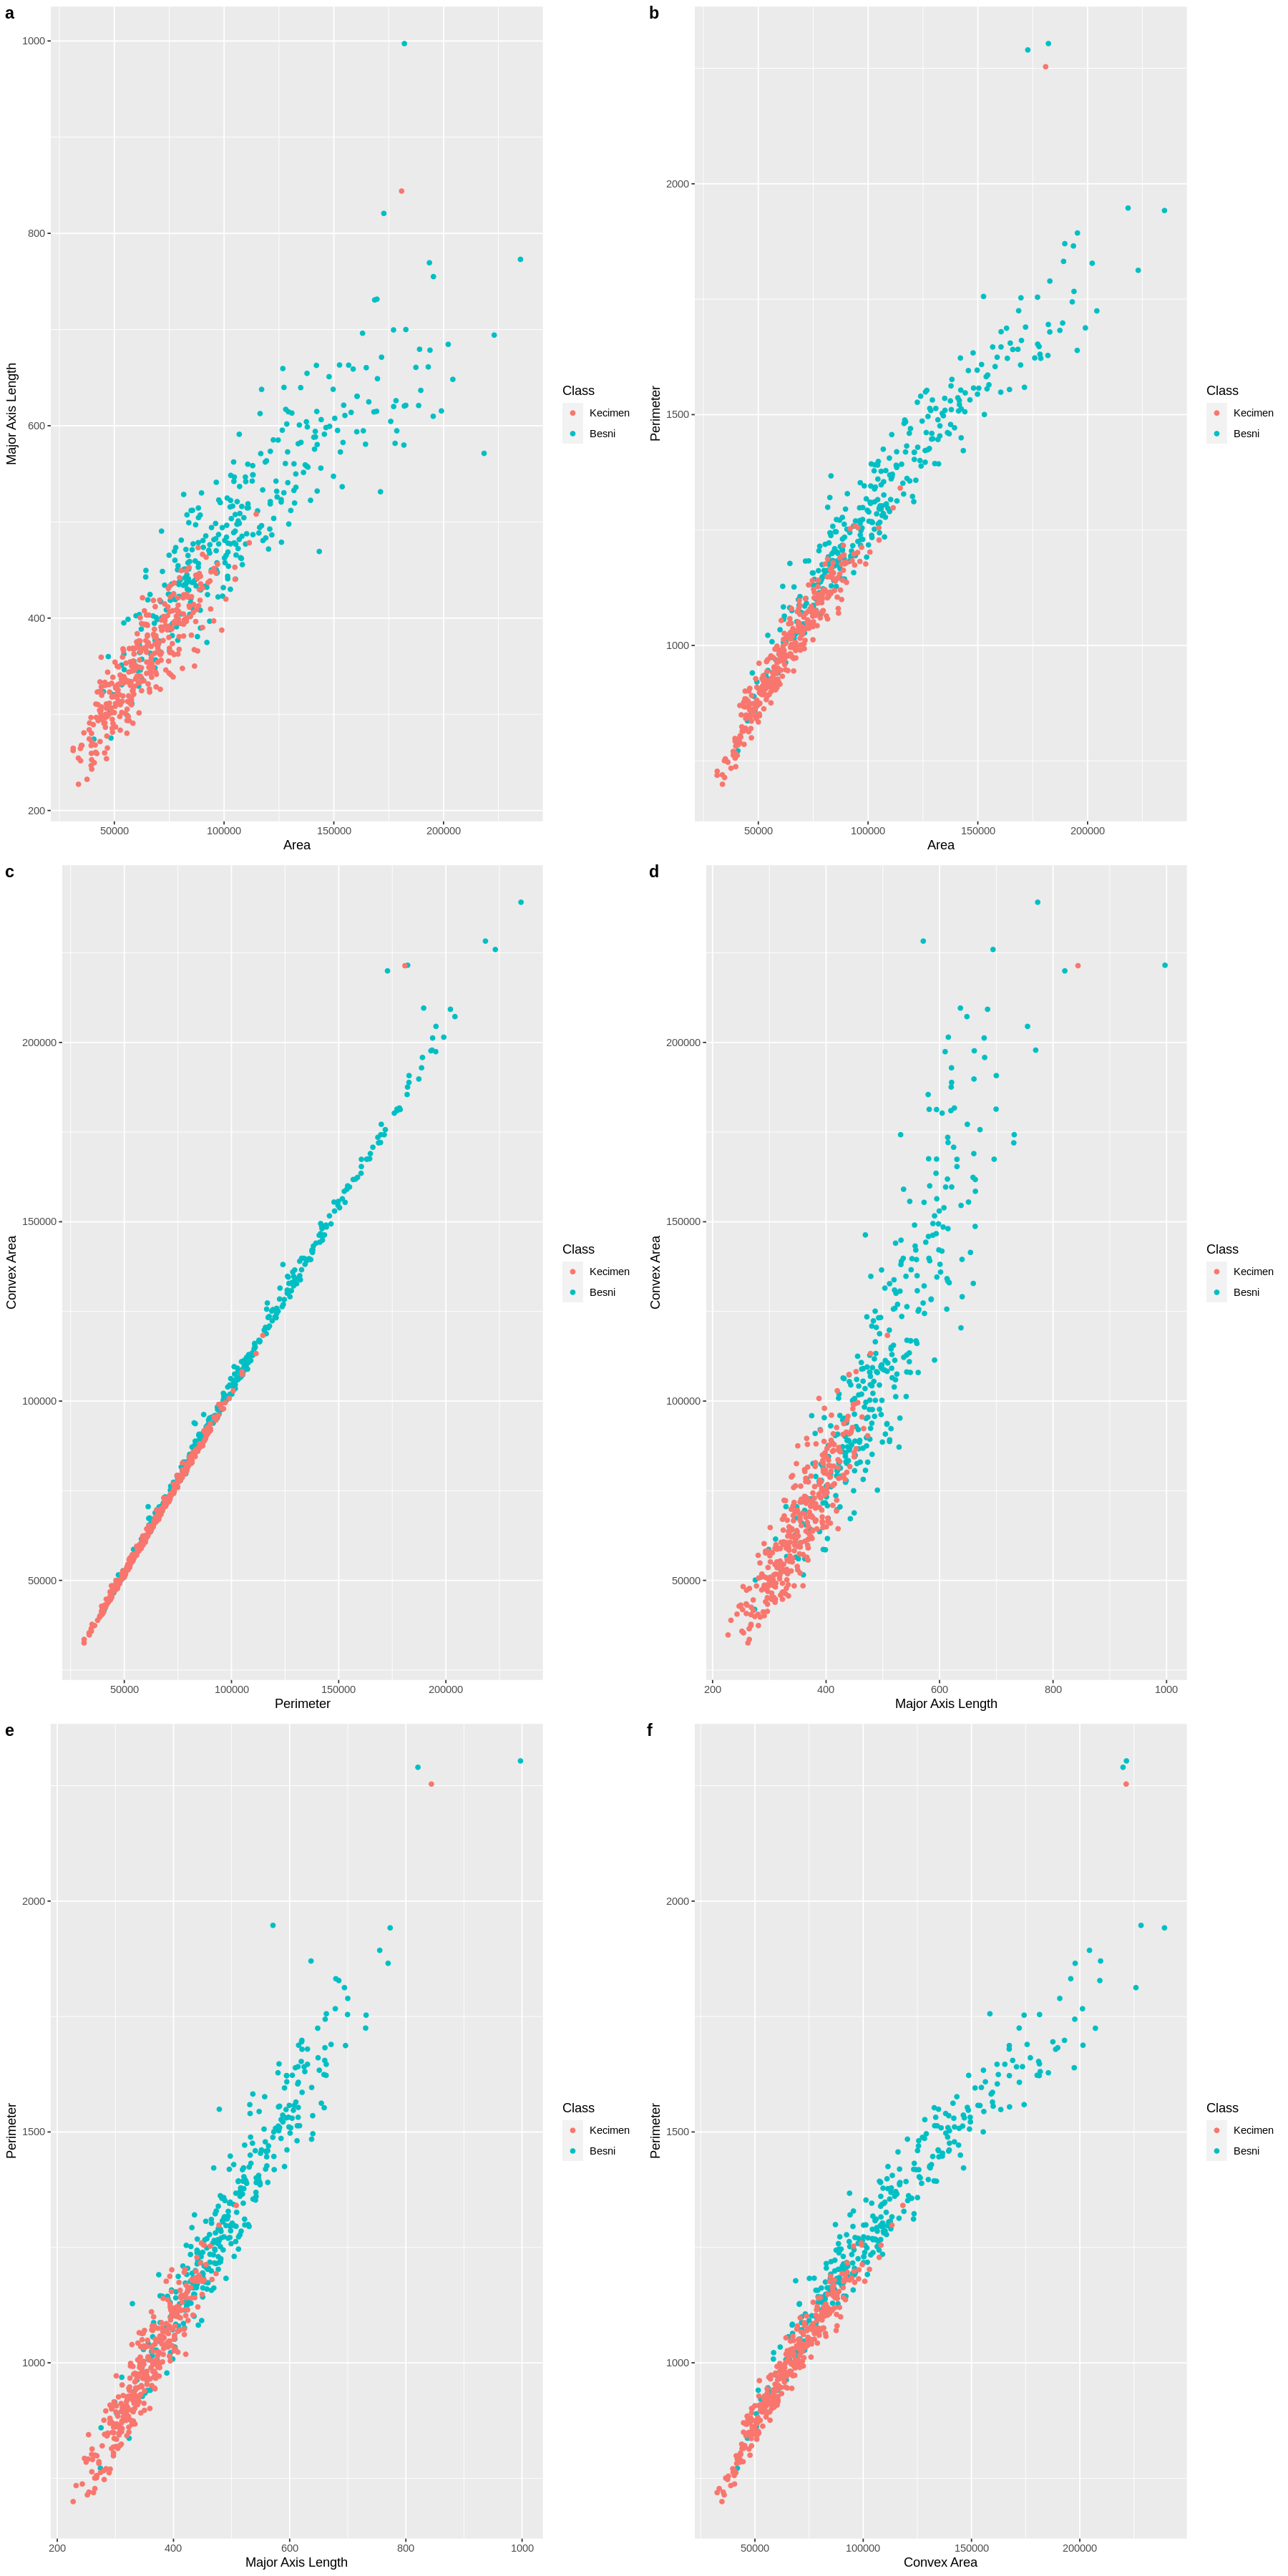

In [35]:
plot_grid(plot_1, plot_2, plot_3, plot_4,
          plot_5, plot_6,
          labels=c('a', 'b', 'c', 'd', 'e', 'f'), ncol = 2)
options(repr.plot.width = 8, repr.plot.height = 10)

Figure 2: Relationship between physical characteristics of two classes of raisins, Kecimen and Besni. (a) Area vs. majour axis length, (b) area vs. perimeter, (c) perimeter vs. convex area, (d) majour axis length vs. convex area, (e) majour axis length vs. perimeter and (f) convex area vs. perimeter. All plots display a strong, positive, linear relationship. 

From the above plots, it is evident that there is a linear positive relationship between all pairings of the selected variables. As area increases, so does convex area, perimeter, and majour axis length, as would be expected based on these types of measurements. Furthermore, besni raisins appear to be generally larger than kecimen raisins in all chosen characteristics, indicating that there is a consistent relationship between the raisons through all pairings. There is greater variation in the values of Besni raisons compared to kecimen raisons and there is a single outlier of the kecimen raison. This outlier would likely be classified as Besni raison by a classification algorithm. 

# Create k-nn Classification model

### 1. Create recipe

In [52]:
raisin_recipe <- recipe(Class ~ Area + MajorAxisLength + Perimeter + ConvexArea, data = raisin_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
raisin_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### 2. Tuning Classifier by cross-validation

In [53]:
#cross-validation
raisin_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

In [54]:
#create model
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [55]:
k_vals <- tibble(neighbors = seq(from = 10, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(raisin_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = raisin_vfold, grid = k_vals) |>
  collect_metrics() 
#find accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.8427349,5,0.007159741,Preprocessor1_Model01
11,accuracy,binary,0.8456321,5,0.007872777,Preprocessor1_Model02
12,accuracy,binary,0.8456321,5,0.007872777,Preprocessor1_Model03
13,accuracy,binary,0.8411545,5,0.009039823,Preprocessor1_Model04
14,accuracy,binary,0.8411545,5,0.009039823,Preprocessor1_Model05
15,accuracy,binary,0.8412643,5,0.009486066,Preprocessor1_Model06
16,accuracy,binary,0.8412643,5,0.009486066,Preprocessor1_Model07
17,accuracy,binary,0.8456760,5,0.008386185,Preprocessor1_Model08
18,accuracy,binary,0.8456760,5,0.008386185,Preprocessor1_Model09


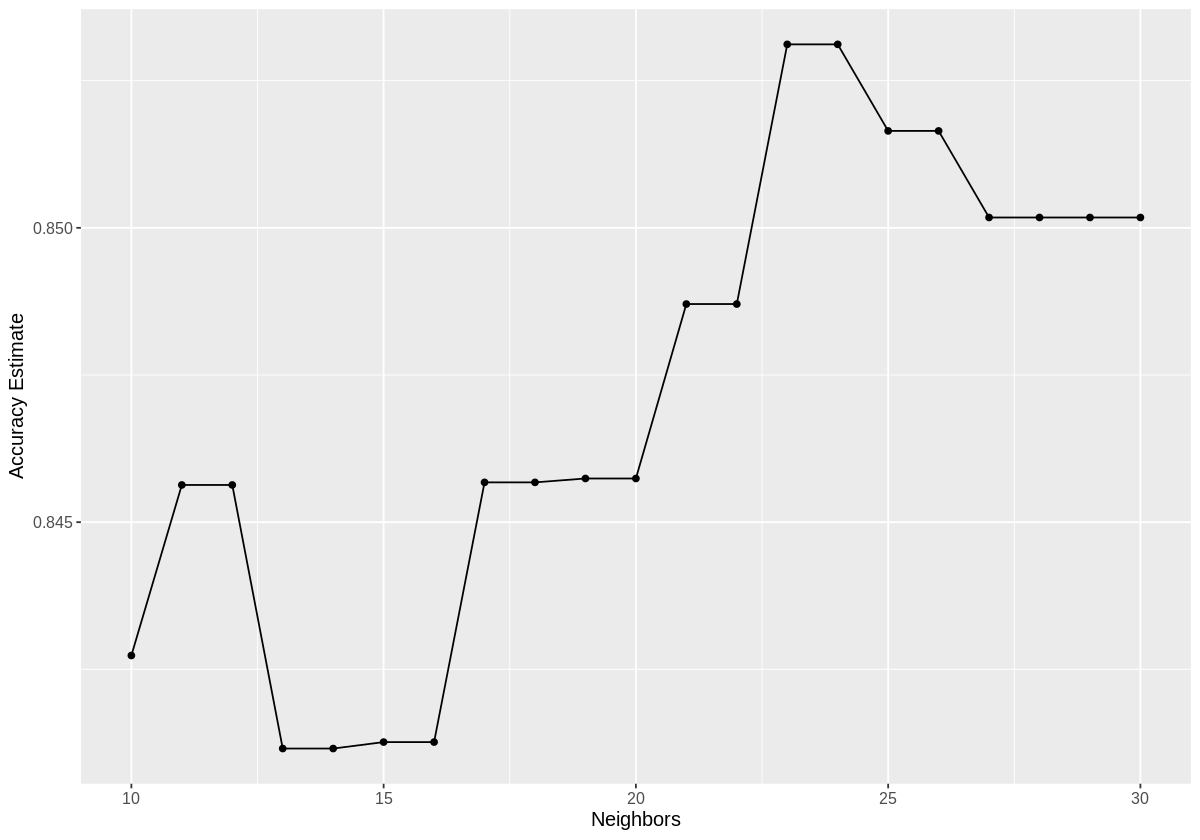

In [56]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
options(repr.plot.width = 10, repr.plot.height = 7)
accuracy_vs_k

Figure 3: Plot of the K value (number of neighbors) compared to the accuracy of the classifier model. 

K values were explored from 10-100 (not shown) and it was determined that a k value somewhere between 10 and 30 would yield the most accurate prediction model. K values between 10 and 30, with values increasing by 1, were plotted against accuracy of the prediction model. From the plot it was determined that the K value of either 23 or 24 would be the most effective in creating an accurate model.  

### 3. Create Model with Optimal K Value

In [68]:
#create model with best k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
  set_engine("kknn") |>
  set_mode("classification")

#fit training data
knn_fit <- workflow() |>
  add_recipe(raisin_recipe) |>

 add_model(knn_spec) |>
  fit(data = raisin_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1557864
Best kernel: rectangular
Best k: 23

### 4. Predict and Check Accuracy

In [69]:
raisin_predictions <- predict(knn_fit, raisin_test) |>
  bind_cols(raisin_test)
glimpse(raisin_predictions)

Rows: 226
Columns: 9
$ .pred_class     <fct> Besni, Besni, Kecimen, Kecimen, Kecimen, Kecimen, Keci…
$ Area            <dbl> 87524, 90856, 79408, 43441, 33565, 57346, 75620, 73167…
$ MajorAxisLength <dbl> 442.2460, 442.2670, 352.1908, 276.6108, 261.5543, 330.…
$ MinorAxisLength <dbl> 253.2912, 266.3283, 290.8275, 201.8131, 167.7085, 222.…
$ Eccentricity    <dbl> 0.8197384, 0.7983536, 0.5640113, 0.6838823, 0.7673743,…
$ ConvexArea      <dbl> 90546, 93717, 81463, 45133, 35794, 59365, 77493, 74545…
$ Extent          <dbl> 0.7586506, 0.6376128, 0.7927719, 0.6908556, 0.6815505,…
$ Perimeter       <dbl> 1184.040, 1208.575, 1073.251, 803.748, 751.413, 928.27…
$ Class           <fct> Kecimen, Kecimen, Kecimen, Kecimen, Kecimen, Kecimen, …


In [70]:
#check accuracy
raisin_predictions |>
  metrics(truth = Class, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8849558


In [71]:
confusion_mat <- raisin_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion_mat

          Truth
Prediction Kecimen Besni
   Kecimen     104    17
   Besni         9    96

We see the accuracy of the model is about 88.50%, which is good.
By looking at the confusion matrix, we have a closer look of our predictions. The model accurately predicted Kecimen 92.20% (n = 104/113) of the time, while it accurately predicted Besni 84.96% of the time (n = 96/113). From this information we can conclude that the model can more accurately predict Kecimen raisons than Besni raisons. 


### 5. Visualizations of the analysis

In [79]:
plot2.1 <- raisin_test |>
    ggplot(aes(x = Area, y= MajorAxisLength, color = Class))+
    geom_point(alpha = 0.6)+
    labs(x = "Area" , y = "Major Axis Length", color = "Class",
        title = "True Class")+
  theme(text = element_text(size = 12))

plot2.2 <- raisin_predictions |>
    ggplot(aes(x = Area, y= MajorAxisLength, color = .pred_class))+
    geom_point(alpha = 0.6)+
    labs(x = "Area" , y = "Major Axis Length", color = "Predicted Class",
        title = "Model Predicted Class")+
  theme(text = element_text(size = 12))


In [73]:
plot2.3 <- raisin_test |>
    ggplot(aes(x = Area, y= ConvexArea, color = Class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 7")+
    labs(x = "Area" , y = "Major Axis Length", color = "Class",
        subtitle="True Area vs. Convex Area")+
  theme(text = element_text(size = 12))

plot2.4 <- raisin_predictions |>
    ggplot(aes(x = Area, y= ConvexArea, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 7")+
    labs(x = "Area" , y = "Major Axis Length", color = "Predicted Class",
        subtitle="Model Predicted Area vs. Convex Area")+
  theme(text = element_text(size = 12))


In [ ]:
plot2.5 <- raisin_test |>
    ggplot(aes(x = Area, y= Perimeter, color = Class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 8")+
    labs(x = "Area" , y = "Perimeter", color = "Class",
        subtitle="True Area vs. Perimeter")+
  theme(text = element_text(size = 12))

plot2.6 <- raisin_predictions |>
    ggplot(aes(x = Area, y= Perimeter, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 8")+
    labs(x = "Area" , y = "Perimeter", color = "Predicted Class",
        subtitle="Model Predicted Area vs. Perimeter")+
    theme(text = element_text(size = 12))


In [75]:
plot2.7 <- raisin_test |>
    ggplot(aes(x = MajorAxisLength, y= ConvexArea, color = Class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 9")+
    labs(x = "Major Axis Length" , y = "Convex Area", color = "Class",
        subtitle = "True Major Axis Length vs. Convex Area")+
      theme(text = element_text(size = 12))

plot2.8 <- raisin_predictions |>
    ggplot(aes(x = MajorAxisLength, y= ConvexArea, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 9")+
    labs(x = "Major Axis Length" , y = "Convex area", color = "Predicted Class",
        subtitle = "Model Predicted Major Axis Length vs. Convex Area")+
      theme(text = element_text(size = 12))

In [76]:
plot2.9 <- raisin_test |>
    ggplot(aes(x = MajorAxisLength, y= Perimeter, color = Class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 9")+
    labs(x = "Major Axis Length" , y = "Perimeter", color = "Class",
        subtitle = "True Major Axis Length vs. Perimeter")

plot2.10 <- raisin_predictions |>
    ggplot(aes(x = MajorAxisLength, y= Perimeter, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 9")+
    labs(x = "Major Axis Length" , y = "Perimeter", color = "Predicted Class",
        subtitle = "Model Predicted Major Axis Length vs. Perimeter")

In [77]:
plot2.11 <- raisin_test |>
    ggplot(aes(x = ConvexArea, y= Perimeter, color = Class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 10")+
    labs(x = "Convex Area" , y = "Perimeter", color = "Class",
        subtitle = "True Convex Area vs. Perimeter")

plot2.12 <- raisin_predictions |>
    ggplot(aes(x = ConvexArea, y= Perimeter, color = .pred_class))+
    geom_point(alpha = 0.6)+
    ggtitle("Figure 10")+
    labs(x = "Convex Area" , y = "Perimeter", color = "Predicted Class",
        subtitle = "Model Predicted Convex Area vs. Perimeter")

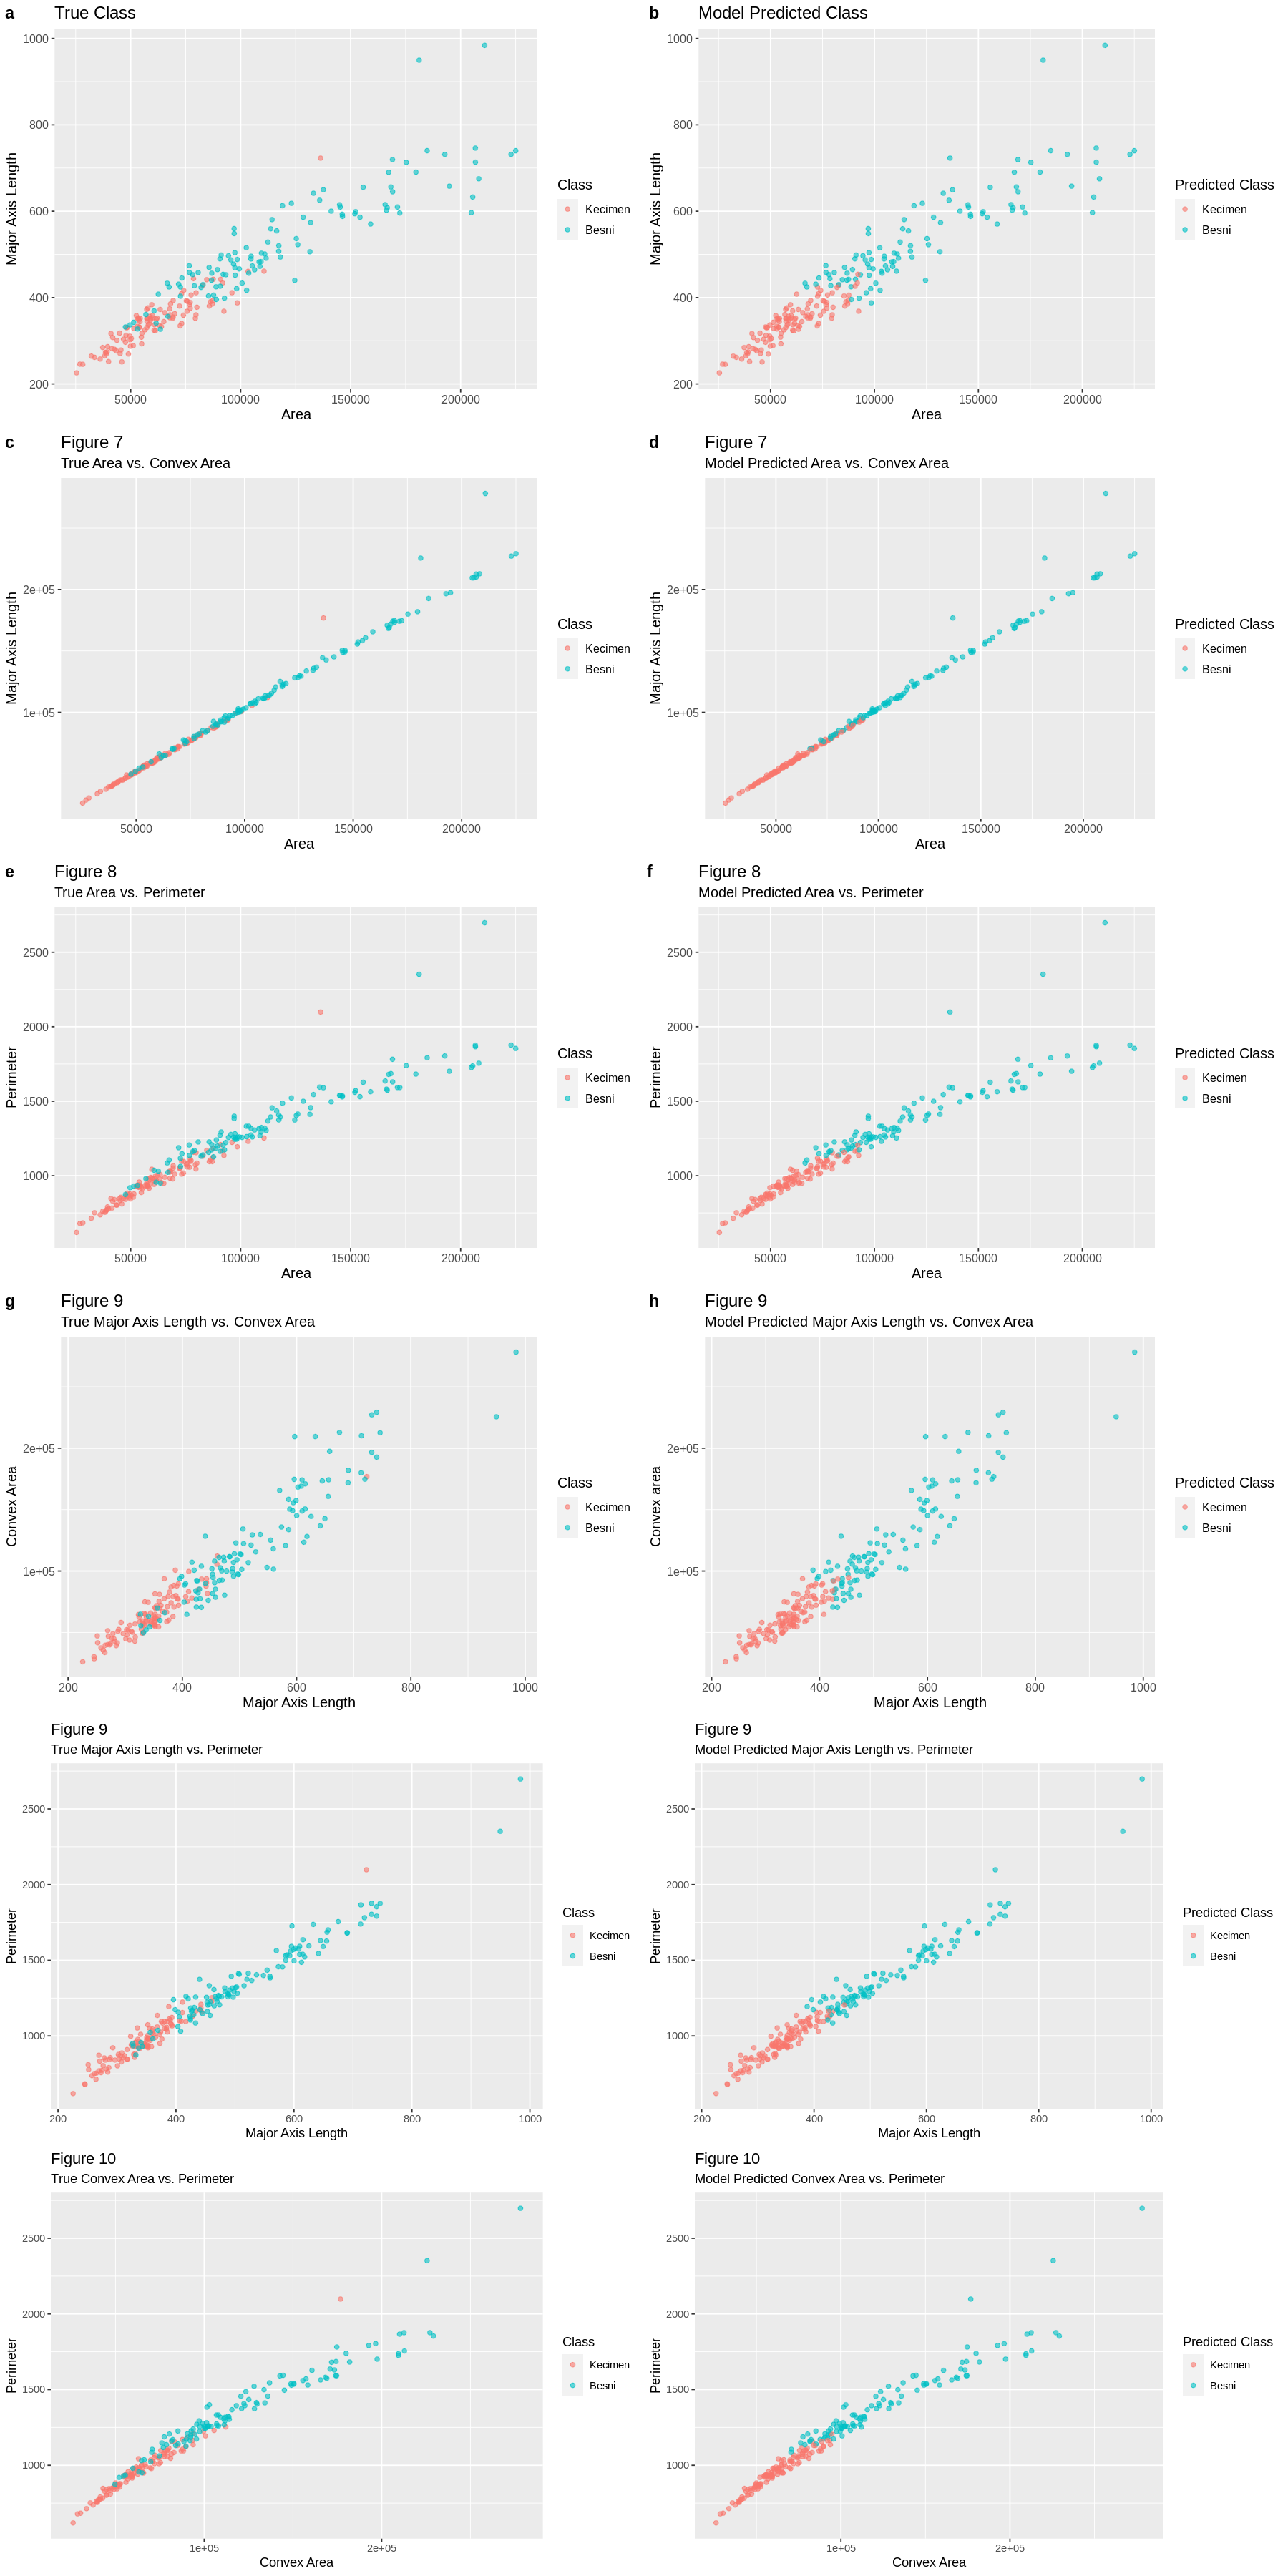

In [81]:
options(repr.plot.width = 15, repr.plot.height = 30)
plot_grid(plot2.1, plot2.2,
          plot2.3, plot2.4,
          plot2.5, plot2.6,
          plot2.7, plot2.8,
          plot2.9, plot2.10,
          plot2.11, plot2.12,
          labels=c('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'), ncol = 2)

Figure 4: Predicted and true class of raisins based on relationships between physical characteristics. Plots a, c, e, g, i, and k display the true classification of the raisins, whereas plots b, d, f, h, and l show the model predicted class of raisin.

Based on Figure 4 we can see several interesting trends have emerged in the accuracy of the prediction model. Firstly, in there is one outlier, a Kecimen bigger than others of its type, that appeared in every plot of true class. This outlier was incorrectly classified as Besni in all instances, which makes sense due to the nature of the K nearest neighbor prediction method. Additionally, we can see that there is greater variation in the physical characteristics of Besni (based on true class) raisins as demonstrated by the data points being more spread out in all but plot (c). However it is expected that plot c is a directly linear relationship as convex area and area are not independent variables. This greater variation of Besni characteristics may be part of the raisin why the prediction model had a lesser accuracy when classifying Besni raisins compared to Kecimen raisins.

# Discussion

Our study focused on comparing two types of raisins - Besni and Kecimen. We found that the number of raisins of each type was relatively similar. However, when it came to size, there were some differences between the two types of raisins. The sizes for Besni raisins were more varied compared to Kecimen raisins. Specifically, larger raisins were classified as Besni, while smaller ones were classified as Kecimen. This suggests that size can be an important factor in distinguishing between the two types of raisins. During our initial research, we found a similar pattern, where Kecimen raisins were naturally smaller in size than Besni raisins.

To classify the raisins, we used a K-nn classification model. This type of classification is impactful in the agricultural industry for ensuring quality control and product consistency. It can also be useful in research and development for new food products.

Overall, the findings provide valuable insights into the differences between Besni and Kecimen raisins, and how they can be classified based on size. Through implementing this information, farmers can better manage their crops and products to ensure that they meet the desired standards of quality and consistency. Additionally, the research can aid in the development of new food products that utilize these types of raisins in different ways.

This study also raises additional questions. Several additional variables may also contribute to the size variation between the two types of raisins. Comparing Besni and Kecimen raisins both grown in similar environments with controlled nutrition, soil, water, and air quality can help provide insight as to why the size disparity exists.# Discussion

# References

Ark of Taste. (2022, December 9). Sour black grape - arca del gusto. Slow Food Foundation. Retrieved April 15, 2023, from https://www.fondazioneslowfood.com/en/ark-of-taste-slow-food/eki-kara-uzumu-sour-black-grape/

Cinar I., Koklu M. and Tasdemir S., (2020), Classification of Raisin Grains Using Machine Vision and Artificial Intelligence Methods. Gazi Journal of Engineering Sciences, vol. 6, no. 3, pp. 200-209, December, 2020

Mikstas, C. (Ed.). (2023, January 5). Raisins: Are they good for you? pros and cons, nutrition information, and more. WebMD. Retrieved April 15, 2023, from https://www.ebmd.com/diet/raisins-good-for-you